visulize results from MFPCA application to T2D microbiome multi-omics dataset

In [35]:
source('../application_code/mfpca_apply_fcns.R')

In [2]:
library(gridExtra)
library(cowplot) # for plot_grid()
library(gridGraphics) # needed for within plot_grid() to deal with R basic plots


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid



### model selection 

In [3]:
dir = '/panfs/panfs1.ucsd.edu/panscratch/lij014/Oct_2020_mfpca/applications/HMP_t2d'

In [4]:
load(paste0(dir, '/results/mfpca_looic_models_microb_protein_cytok_a1c_compare.RData'))

In [5]:
looic.compare 

,elpd_diff,se_diff
,<dbl>,<dbl>
model2,0.000000,0.000000
model3,-3.308077,4.127580
model1,-4.214945,2.647399


In [6]:
mdl_idx = 2
load(paste0(dir, '/results/mfpca_t2d_microb_protein_cytok_a1c_', mdl_idx, '.RData'))

In [7]:
mdl_list[[paste0('mdl', mdl_idx)]]

$num_PCs
[1] 2 4 4 4

$nknots
[1] 1 1 1 1

In [8]:
post_rotation_results <- post_hoc_rotation(fit = fit, Nchains = Nchains, Nsamples = Nsamples, 
									       N = pca_data$N, P = pca_data$P, K = pca_data$K, Q = pca_data$Q)
mfpca_results <- output_mfpca(dat_mfpca, param_stan, post_rotation_results, 
                              title = c('bacterial', 'protein', 'cytok', 'A1c')) 

In [9]:
mfpca_results$prop_var_avg

[[1]]
[1] 0.7904409 0.2095591

[[2]]
[1] 0.67531899 0.22855789 0.08103692 0.01508620

[[3]]
[1] 0.82888812 0.13279760 0.03194978 0.00636450

[[4]]
[1] 0.701985495 0.236239064 0.053522741 0.008252699

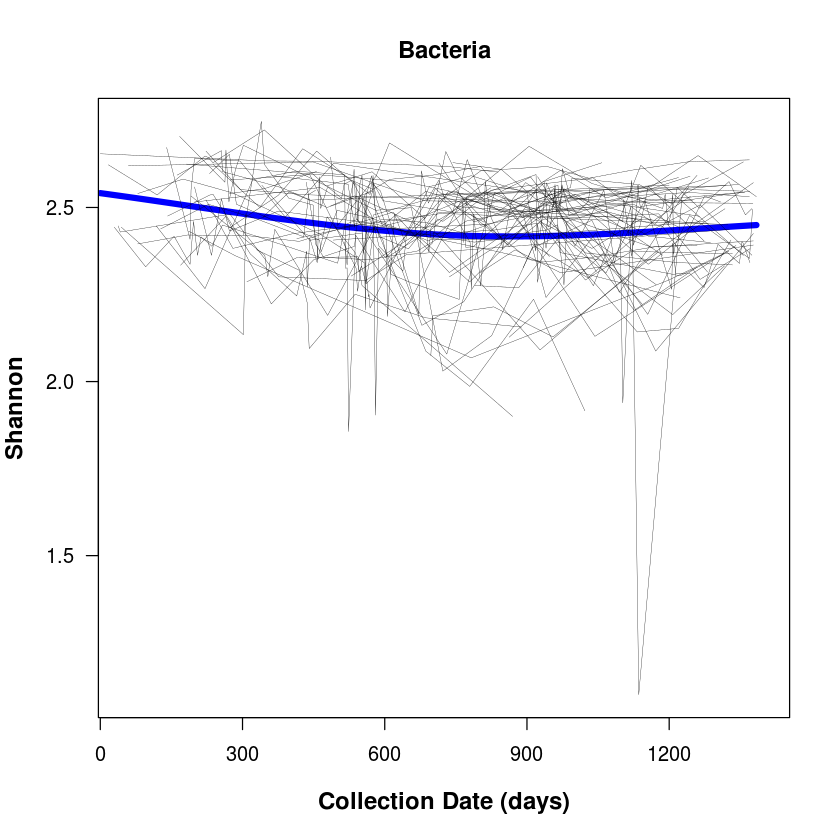

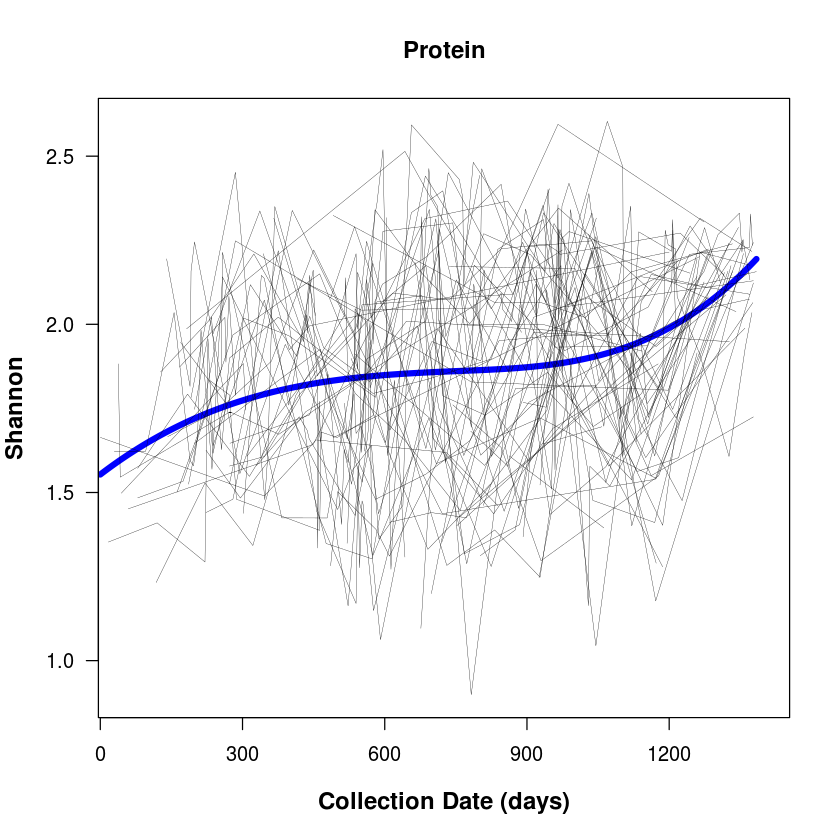

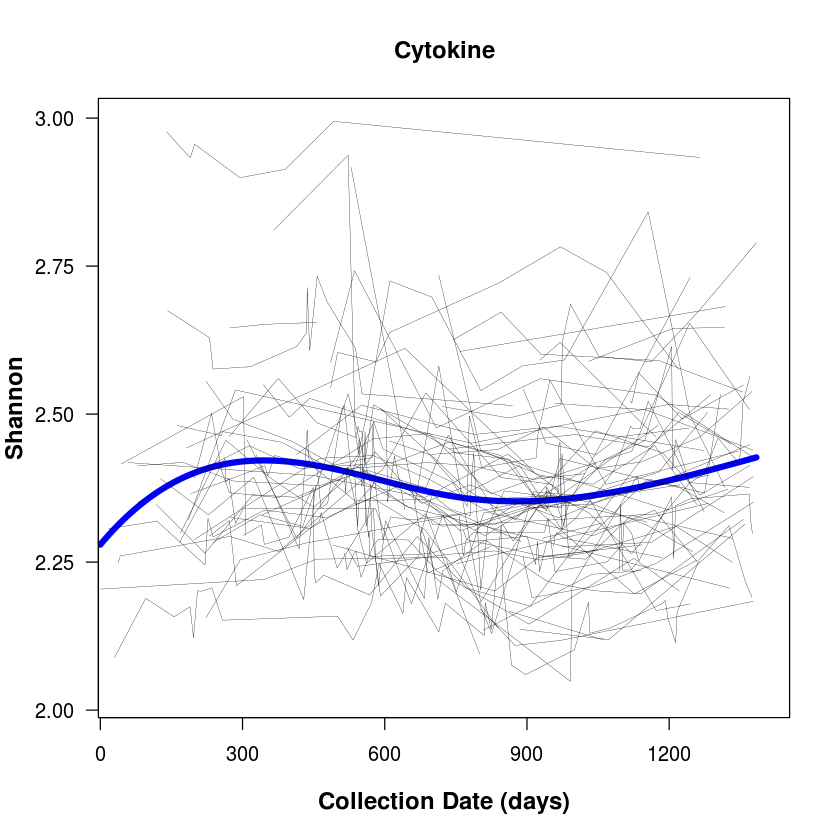

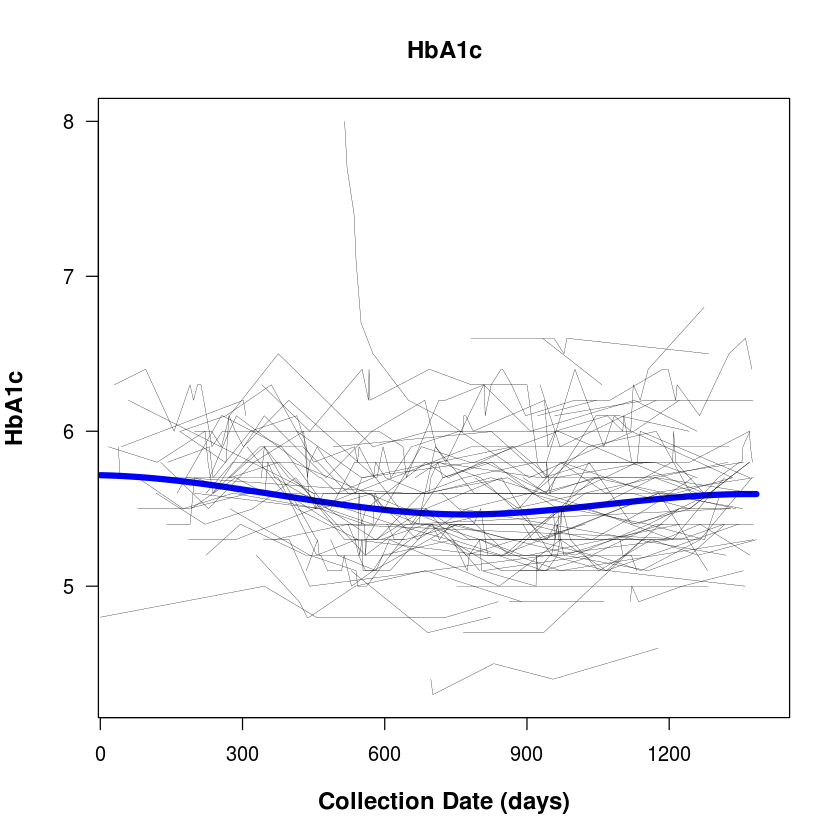

In [11]:
figs <- plots_mfpca(output_mfpca = mfpca_results, plot_mean = TRUE, 
                    mean_x_label = 'Collection Date (days)', 
                    mean_y_label = c(rep('Shannon',3), 'HbA1c'), 
                    mean_x_range = list(c(50,1400), c(50,1400), c(50,1400), c(50,1400)),
                    mean_y_ticks = list(c(1.5,2,2.5), c(1,1.5,2,2.5), c(2, 2.25, 2.5, 2.75, 3), c(5,6,7,8)),
                    mean_x_ticks = list(seq(0, 1400, 300), seq(0, 1400, 300), seq(0, 1400, 300), seq(0, 1400, 300)),
                    mean_title = c('Bacteria', 'Protein', 'Cytokine', 'HbA1c'),
                    plot_fpc = TRUE, 
                    fpc_y_label = c(rep('Shannon',3), 'HbA1c'),
                    fpc_x_label = 'Collection Date (days)',
                    fpc_title = c('Bacterial FPC curves', 'Protein FPC curves', 
                                  'Cytokine FPC curves', 'HbA1c FPC curves'),
                     fpc_y_lim = list(c(1.5,3), c(1,2.5), c(2,3), c(5,8)),
                    fpc_y_ticks = list(c(1.5,2,2.5,3), c(1,1.5,2,2.5), c(2, 2.25, 2.5, 2.75, 3), c(5,6,7,8)),
                    fpc_x_ticks = list(seq(0, 1400, 300), seq(0, 1400, 300), seq(0, 1400, 300), seq(0, 1400, 300)),
                    plot_fpc_scores = FALSE)

### figure 1: FPC mean curves

In [12]:
fig_mean_microbe = figs$figs_mean_list[[1]]
fig_mean_protein = figs$figs_mean_list[[2]]
fig_mean_cytok = figs$figs_mean_list[[3]]
fig_mean_a1c = figs$figs_mean_list[[4]]

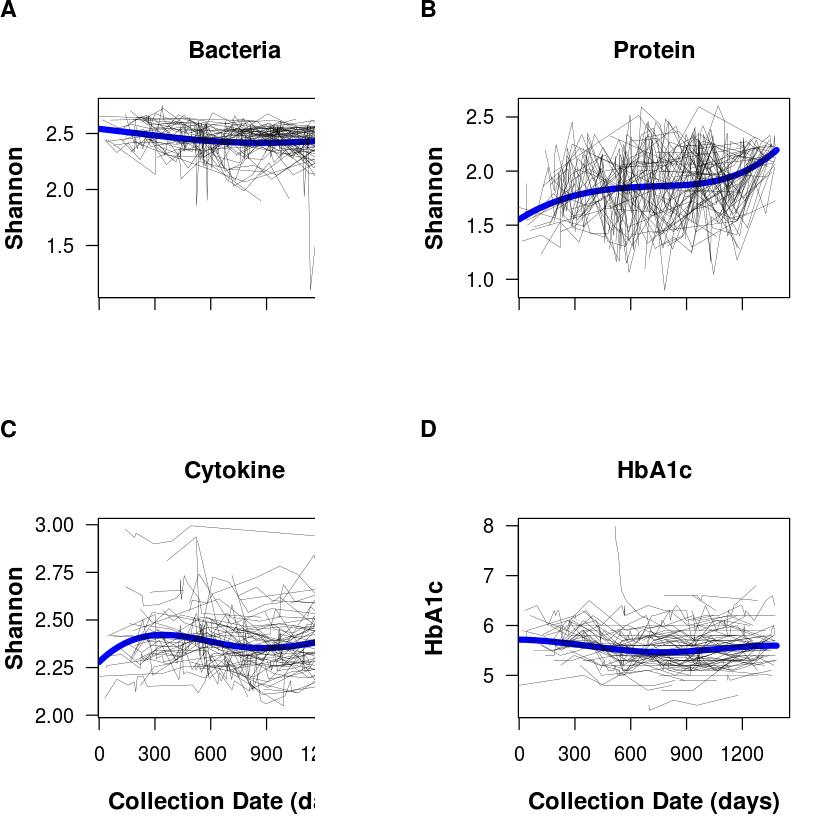

In [33]:
# ggsave() produces error on barnacle (applied to all other figure saving as well)
# use figures generated from local computer instead (checked: the same)
plot_grid(fig_mean_microbe, fig_mean_protein, fig_mean_cytok, fig_mean_a1c,
          labels = c('A', 'B', 'C', 'D'), 
          hjust = 0, vjust = 1) 
#ggsave('../figures/application_2_fig1.png', width=7, height=7, dpi=300)

### figure 2: FPC curves

In [21]:
fig_fpc_microbe = figs$figs_fpc_list[[1]]
fig_fpc_protein = figs$figs_fpc_list[[2]]
fig_fpc_cytok = figs$figs_fpc_list[[3]]
fig_fpc_a1c = figs$figs_fpc_list[[4]]

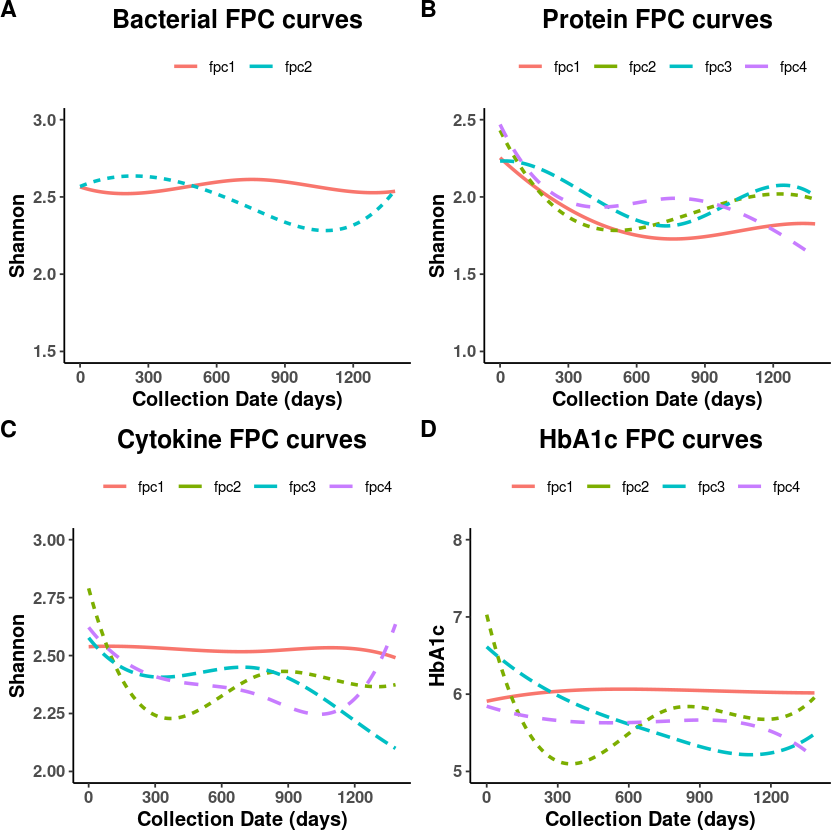

In [22]:
plot_grid(fig_fpc_microbe, fig_fpc_protein, fig_fpc_cytok, fig_fpc_a1c,
          labels = c('A', 'B', 'C', 'D'), 
          hjust = 0, vjust = 1) 
ggsave('../figures/application_2_fig2.png', width=7, height=7, dpi=300)

### figure 3: model diagnostics + outliers examinations

In [36]:
fig_looic = diagnostic_looic(loo_list=looic.list[[mdl_idx]], num_subjects=pca_data$N) 

In [37]:
fig_posterior = diagnostic_posterior(mfpca_fit=fit, Nsamples=Nsamples, Nchains=Nchains, 
                     visits_matrix=pca_data$V, response_observed=pca_data$Y,
				     fig_title='posterior predictive checking') 

In [38]:
N = pca_data$N; loo_list=looic.list[[mdl_idx]]
pkdf <- data.frame(pk=loo_list$diagnostics$pareto_k, id=1:N)
outlier = dat_mfpca$data[dat_mfpca$data$SubjectUnique %in% unique(dat_mfpca$data$SubjectUnique)[
                                                                pkdf$id[pkdf$pk > 0.7]], ]

outlier_microb <- ggplot(outlier, aes(x=CollectionDate, y=shannon_microb)) + geom_line(alpha=0.5) + guides(colour=FALSE) + 
                xlab("Collection Date (days)") + ylab("Shannon") + aes(colour = factor(SubjectUnique)) +
                theme_classic() + ggtitle("Bacterial") +
                theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"),
                      axis.text = element_text(size=10, color='black'),
                      axis.title.x = element_text(size=12,face="bold"),
                      axis.title.y = element_text(size=12,face="bold")) +
                scale_fill_distiller(palette = "Spectral") + ylim(1.5, 3) + xlim(50, 1400)

outlier_protein <- ggplot(outlier, aes(x=CollectionDate, y=shannon_protein)) + geom_line(alpha=0.5) + guides(colour=FALSE) + 
                xlab("Collection Date (days)") + ylab("Shannon") + aes(colour = factor(SubjectUnique)) +
                theme_classic() + ggtitle("Protein") +
                theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"),
                      axis.text = element_text(size=10, color='black'),
                      axis.title.x = element_text(size=12, face="bold"),
                      axis.title.y = element_text(size=12, face="bold")) + 
                scale_fill_distiller(palette = "Spectral") + ylim(1, 2.5) + xlim(50, 1400)

outlier_cytok <- ggplot(outlier, aes(x=CollectionDate, y=shannon_cytok)) + geom_line(alpha=0.5) + guides(colour=FALSE) + 
                xlab("Collection Date (days)") + ylab("Shannon") + aes(colour = factor(SubjectUnique)) +
                theme_classic() + ggtitle("Cytokine") +
                theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"),
                      axis.text = element_text(size=10, color='black'),
                      axis.title.x = element_text(size=12, face="bold"),
                      axis.title.y = element_text(size=12, face="bold")) + 
                scale_fill_distiller(palette = "Spectral") + ylim(2, 3) + xlim(50, 1400)

outlier_A1C <- ggplot(outlier, aes(x=CollectionDate, y=A1C)) + geom_line(alpha=0.5) + guides(colour=FALSE) + 
                xlab("Collection Date (days)") + ylab("HbA1c") + aes(colour = factor(SubjectUnique)) +
                theme_classic() + ggtitle("HbA1c") +
                theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"),
                      axis.text = element_text(size=10, color='black'),
                      axis.title.x = element_text(size=12, face="bold"),
                      axis.title.y = element_text(size=12, face="bold")) +
                scale_fill_distiller(palette = "Spectral") + ylim(5, 8) + xlim(50, 1400)

In [ ]:
# ZLGD9M0 (day 201-1270) (red; cytok, A1C): healthy -- infection -- healthy (metab + protein)
# ZN3TBJM (day 229-1376) (green; cytok, protein): healthy -- Imz -- infection -- infection_L -- healthy -- Imz -- Imz_L -- infection -- ant -- Imz
# ZOZOW1T (day 96-1375) (blue; protein): healthy -- infection -- Imz -- healthy -- infection_L -- healthy -- infection -- infection_L -- ant -- healthy -- infection -- 
# -- healthy -- Imz -- infection -- post-travel -- allergy -- healthy 
# ZVNCGHM (day 558-1229) (purple; A1C): infection/infection_L -- stress -- healthy 

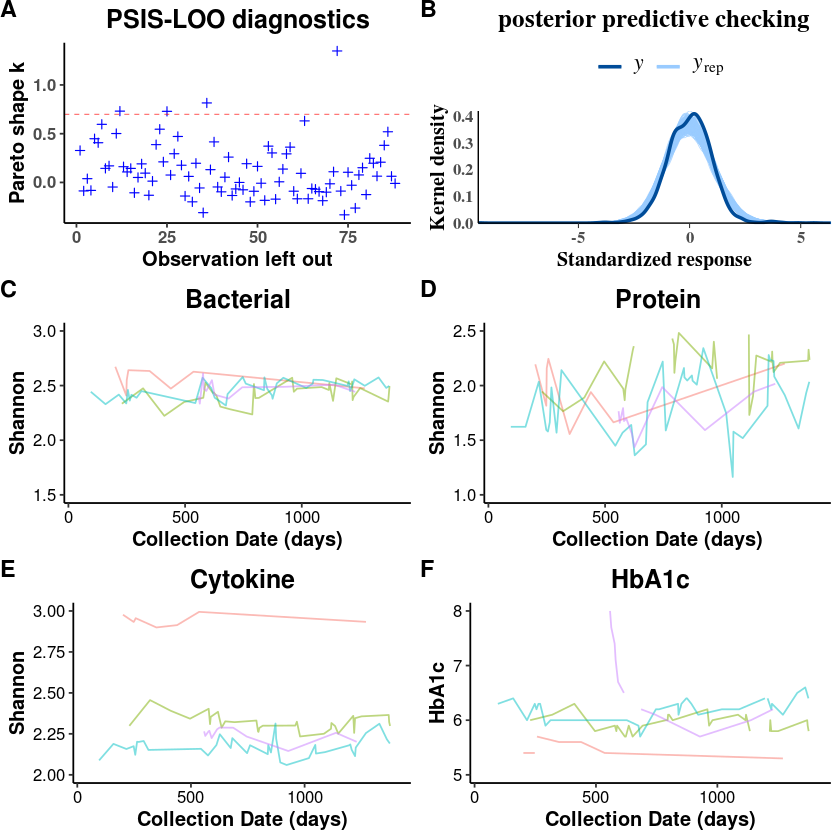

In [40]:
plot_grid(fig_looic, fig_posterior, outlier_microb, outlier_protein, outlier_cytok, outlier_A1C, 
          labels = c('A', 'B', 'C', 'D', 'E', 'F'), 
          hjust = 0, vjust = 1, nrow=3) 
ggsave('../figures/application_2_fig3.png', width=6, height=9, dpi=300)

### Figure 4: mutual information

In [41]:
MI_results <- MI_est_data(post_rotation_results=post_rotation_results, K=pca_data$K)

In [42]:
MI_results

$MI_12_list
              50%     2.5%    97.5% 
2.154650 2.373599 0.724182 3.372265 

$MI_13_list
                50%      2.5%     97.5% 
0.7485567 0.5307754 0.1153815 1.5495040 

$MI_14_list
                50%      2.5%     97.5% 
0.3890882 0.4038325 0.1083725 0.6545870 

$MI_23_list
                50%      2.5%     97.5% 
1.5570670 1.3477833 0.7681913 2.8741502 

$MI_24_list
                50%      2.5%     97.5% 
0.9742681 1.0099576 0.4808139 1.4287595 

$MI_34_list
                50%      2.5%     97.5% 
0.6906891 0.6031054 0.2949970 1.2010404 

$CMI_12_list
              50%     2.5%    97.5% 
4.955381 4.534165 2.442477 8.170295 

$CMI_13_list
              50%     2.5%    97.5% 
3.522988 3.674169 1.248379 6.359435 

$CMI_14_list
                50%      2.5%     97.5% 
1.7173405 1.2763594 0.5568535 3.9846629 

$CMI_23_list
              50%     2.5%    97.5% 
4.847223 4.390749 2.635300 7.898516 

$CMI_24_list
              50%     2.5%    97.5% 
2.818245 2.450662 1.375040 5.151397 

$CMI_34_list
              50%     2.5%    97.5% 
2.508367 2.104114 1.178781 4.835400 

$norm_MI_12_list
                50%      2.5%     97.5% 
0.9818084 0.9956526 0.8746686 0.9994112 

$norm_MI_13_list
                50%      2.5%     97.5% 
0.7982885 0.8087524 0.4539520 0.9771928 

$norm_MI_14_list
                50%      2.5%     97.5% 
0.7095670 0.7443802 0.4414347 0.8543752 

$norm_MI_23_list
                50%      2.5%     97.5% 
0.9655872 0.9656583 0.8859130 0.9984046 

$norm_MI_24_list
                50%      2.5%     97.5% 
0.9103611 0.9313073 0.7859578 0.9708700 

$norm_MI_34_list
                50%      2.5%     97.5% 
0.8485811 0.8370607 0.6675827 0.9536614 

$norm_CMI_12_list
                50%      2.5%     97.5% 
0.9995658 0.9999424 0.9962131 1.0000000 

$norm_CMI_13_list
                50%      2.5%     97.5% 
0.9953062 0.9996781 0.9579396 0.9999985 

$norm_CMI_14_list
                50%      2.5%     97.5% 
0.9565191 0.9602762 0.8195486 0.9998270 

$norm_CMI_23_list
                50%      2.5%     97.5% 
0.9996258 0.9999232 0.9974253 0.9999999 

$norm_CMI_24_list
                50%      2.5%     97.5% 
0.9935982 0.9962747 0.9675079 0.9999832 

$norm_CMI_34_list
                50%      2.5%     97.5% 
0.9861173 0.9925358 0.9514976 0.9999684